# yolo이용한 사진 crop

In [ ]:
# 사진 crop

from ultralytics import YOLO
import cv2
import os
import numpy as np


def yolo_crop(folder_path, crop_output):

    model = YOLO("../yolo_weight/yolov8n-face.pt")

    crop_list= []
    cant = []

    print(folder_path)

    if  os.path.isdir(folder_path):
        for root, _, files in os.walk(folder_path):
            for file_name in files:
                image_path = os.path.join(root, file_name)
                img = cv2.imread(image_path)
                
                results = model.predict(img, show=False, batch=8)
                boxes = results[0].boxes.xyxy.cpu().tolist()
                clss = results[0].boxes.cls.cpu().tolist()
                
                if boxes is not None:
                    for box, cls in zip(boxes, clss):
                        crop_obj = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
                        save_path = os.path.join(crop_output, file_name)
                        cv2.imwrite(save_path, crop_obj)
                        # crop_list.append(save_path)
                else:
                    cant.append(image_path)
                    pass
    else:
        img = cv2.imread(folder_path)
        results = model.predict(img, show=False, batch=8)
        boxes = results[0].boxes.xyxy.cpu().tolist()
        clss = results[0].boxes.cls.cpu().tolist()
        
        if boxes is not None:
            for box, cls in zip(boxes, clss):
                crop_obj = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
                file_name = os.path.basename(folder_path)
                save_path = os.path.join(crop_output, file_name)
                cv2.imwrite(save_path, crop_obj)
                crop_list.append(save_path)
        else:
            cant.append(folder_path)
            pass

    if cant is not None:
        np.savetxt('../cantlist/cant_crop.txt', cant, fmt='%s')


# crop 이미지를 resnet을 이용하여 임베딩

In [2]:
#yolo로 crop한것 embedding

from facenet_pytorch import InceptionResnetV1
import torchvision.transforms as transforms
import os
from PIL import Image
import numpy as np

def resnet_embedding(folder_path, save_folder):

    resnet = InceptionResnetV1(pretrained='vggface2').eval()

    transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    emb_list = []
    cant = []

    for root, _, files in os.walk(folder_path):
        for file_name in files:
            image_path = os.path.join(root, file_name)
            img = Image.open(image_path).convert('RGB')
            img = transform(img).unsqueeze(0)

            if img is not None :
                embedding = resnet(img).detach()
                save_embeding = embedding.numpy()
                save_path = os.path.join(save_folder, file_name.replace('.png', '.npy'))
                np.save(save_path, save_embeding)
                emb_list.append(save_path)
            else:
                cant.append(image_path)
                pass
    
    if cant is not None:
        np.savetxt('../cant_emb_list.txt', cant, fmt='%s')
        



# crop이미지 MTCNN을 이용한 랜드마크 임베딩

In [6]:
# MTCNN을 이용한 랜드마크

from facenet_pytorch import MTCNN
from sklearn.metrics.pairwise import euclidean_distances
from PIL import Image
import os
def mtcnn_landmark(input_folder_path, save_folder_path):

    mtcnn = MTCNN(image_size=160, margin= 50)

    emb_list = []
    cant = []

    for root, _, files in os.walk(input_folder_path):
        for file_name in files:
            image_path = os.path.join(root, file_name)
            img = Image.open(image_path)
            img = img.convert("RGB")

            _, probs, landmarks = mtcnn.detect(img, landmarks=True)

            if probs:
                landmarks_2d = landmarks.reshape(-1, 2)
                distances = euclidean_distances(landmarks_2d)
                embedding = distances[np.triu_indices(len(landmarks_2d), k=1)]
                embedding = np.array(embedding)
                save_path = os.path.join(save_folder_path, file_name.replace('.png', '.npy'))
                np.save(save_path, embedding)
            else:
                pass

In [ ]:
# mtcnn으로 못 읽은것들 txt 파일 읽어서 얼마나 있는지 라인수(얼굴 못찾은 파일수) 읽기
file_path = "../cantlist/cant_2dlm_list.txt"  # 텍스트 파일의 경로

# 파일을 읽기 모드로 엽니다
with open(file_path, "r") as file:
    # 파일의 내용을 읽어서 lines 리스트에 저장합니다
    lines = file.readlines()
num_lines = len(lines)
print("파일의 라인 수:", num_lines)
# for line in lines:
#     print(line.strip())

# crop 이미지 FAN을 이용한 랜드마크 임베딩

In [ ]:
# FAN landmark

import face_alignment
from skimage import io
from sklearn.metrics.pairwise import euclidean_distances
import os
import numpy as np
import cv2

EYEBROW_L = (17, 21)
EYEBROW_R = (22, 26)
BETWEEN_BROWS = (21, 22)
EYE_L = (36, 39)
EYE_R = (43, 45)
NOSE_W = (31, 25)
NOSE_L = (27, 33)
LIP = (48, 54)
FACE_W = (1, 15)

def fan_lanmark(input_folder_path, save_folder_path):

    model = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=False, face_detector='sfd')

    cant = []

    for root, _, files in os.walk(input_folder_path):
        for file_name in files:
            image_path = os.path.join(root, file_name)
            input = io.imread(image_path)
            resized_image = cv2.resize(input, (160, 160))
            preds = model.get_landmarks(resized_image)

            if preds is not None:  # 랜드마크가 검출되었는지 확인
                distances = []
                # 원하는 랜드마크 쌍의 인덱스 지정
                landmark_indices = [EYEBROW_L, EYEBROW_R, BETWEEN_BROWS, EYE_L, EYE_R, NOSE_L, NOSE_W, LIP, FACE_W]
                for idx1, idx2 in landmark_indices:
                    # 두 지점 간의 거리 계산하여 distances 리스트에 추가
                    distance = euclidean_distances([preds[0][idx1]], [preds[0][idx2]])[0][0]
                    distances.append(distance)

                distances = np.array(distances)
                distances = distances.reshape(1, -1)
                save_path = os.path.join(save_folder_path, file_name.replace('.png', '.npy'))
                # np.save(save_path, distances)
            else:
                cant.append(file_name)
                pass
    if cant is not None:
        np.savetxt('../cantlist/cant_fan_list.txt', cant, fmt='%s')



In [180]:
# 얼굴 못 찾은 파일수를 확인하기위해서
file_path = "../cantlist/cant_fan_list.txt"  # 텍스트 파일의 경로

# 파일을 읽기 모드로 엽니다
with open(file_path, "r") as file:
    # 파일의 내용을 읽어서 lines 리스트에 저장합니다
    lines = file.readlines()
num_lines = len(lines)
print("파일의 라인 수:", num_lines)

파일의 라인 수: 14


# npy 파일합치기

In [7]:
# embedding.npy 합치기
# 이거 헷갈리네 차원이 늘어나면 안돼?왜?
# concat?

import os
import numpy as np

# 같은 사람(앞 숫자 네자리)끼리 모아서 dict 생성
def collect_same_person(input_path= None, output_folder=None):
    # 파일 이름을 네 자리 숫자로 그룹화하기 위한 딕셔너리 생성
    file_groups = {}

    # 폴더 내의 모든 파일 탐색
    for root, _, files in os.walk(input_path):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            if file_name.endswith('.npy'):
                prefix = file_name[:4]
                # 해당 그룹에 파일 추가
                if prefix in file_groups:
                    file_groups[prefix].append(file_path)
                else:
                    file_groups[prefix] = [file_path]

    combine_vecs(file_groups, output_folder)

# 위에서 만든 dict를 이용해서 하나의 npy 파일 만들기
def combine_vecs(file_groups, output_folder):
    for prefix, files in file_groups.items():
        combined_data = []
        for file_path in files:
            print(file_path)
            data = np.load(file_path, allow_pickle=True)
            combined_data.append(data)
        # 그룹 내의 모든 데이터 결합
        # print(combined_data)
        combined_data = np.concatenate(combined_data, axis=0)
        
        # 결합된 데이터를 새 파일로 저장
        output_file_path = os.path.join(output_folder, f'{prefix}_combined.npy')
        np.save(output_file_path, combined_data)

../lm_dist_test/base_emb/3138_outdoor_direct_mask_distance1_00000031.npy
../lm_dist_test/base_emb/3069_outdoor_back_normal_distance1_00000200.npy
../lm_dist_test/base_emb/3069_indoor_normal_distance1_00000162.npy
../lm_dist_test/base_emb/3069_outdoor_direct_mask_distance2_00000310.npy
../lm_dist_test/base_emb/3069_indoor_mask_distance1_00000208.npy
../lm_dist_test/base_emb/3077_outdoor_direct_hat_distance1_00000173.npy
../lm_dist_test/base_emb/3077_outdoor_back_mask_distance1_00000224.npy
../lm_dist_test/base_emb/3091_outdoor_direct_mask_distance2_00000000.npy
../lm_dist_test/base_emb/3091_outdoor_back_normal_distance2_00000144.npy
../lm_dist_test/base_emb/3091_outdoor_back_hat_distance1_00000371.npy
../lm_dist_test/base_emb/2951_outdoor_back_normal_distance2_00000286.npy
../lm_dist_test/base_emb/2943_indoor_mask_distance2_00000248.npy
../lm_dist_test/base_emb/2882_indoor_hat_distance1_00000248.npy
../lm_dist_test/base_emb/2882_outdoor_direct_hat_distance1_00000283.npy
../lm_dist_test/

In [8]:
# emb와 landmark 하나로 합치기

import os
import numpy as np

def merge_vec_files(folder1, folder2, output_folder):
   # 폴더 내의 파일 목록 가져오기
    files1 = os.listdir(folder1)
    files2 = os.listdir(folder2)
    
    # 폴더1과 폴더2의 공통 파일 이름 찾기
    common_names = set(files1) & set(files2)
    
    # 공통 파일 이름을 가진 파일을 읽고 병합하여 저장
    for file_name in common_names:
        if file_name.endswith('.npy'):
            file_path1 = os.path.join(folder1, file_name)
            file_path2 = os.path.join(folder2, file_name)
            data1 = np.load(file_path1).reshape(1,-1)
            data2 = np.load(file_path2, allow_pickle=True).reshape(1,-1)

            # 두 배열의 길이를 맞추고 모자라는 부분은 0으로 채웠음 이거 물어보기
            resized_data2 = np.zeros_like(data1)
            resized_data2[:, :data2.shape[1]] = data2

            # 데이터 병합
            merged_data = np.concatenate([data1, resized_data2])
            
            # 병합된 데이터 저장
            output_path = os.path.join(output_folder, file_name)
            np.save(output_path, merged_data)



# Auto Threshold 구하기

[363.83688374]


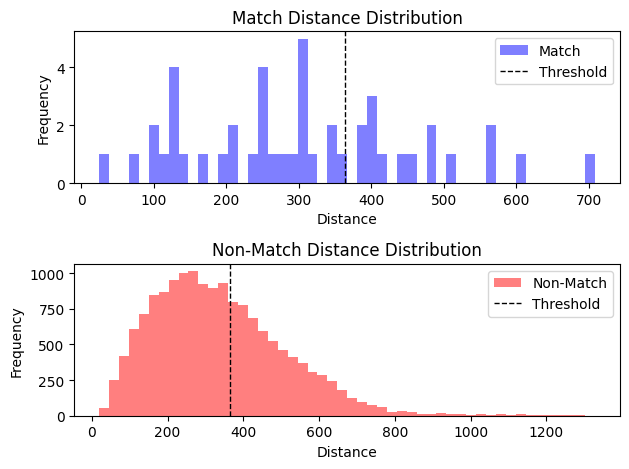

In [115]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import mixture

def plot_histogram(data1, data2, threshold):
    fig, axs = plt.subplots(2)
    
    # 첫 번째 subplot에 히스토그램 그리기
    axs[0].hist(data1, bins=50, color='blue', alpha=0.5, label='Match')
    axs[0].axvline(x=threshold, color='black', linestyle='--', linewidth=1, label='Threshold')
    axs[0].set_title('Match Distance Distribution')
    axs[0].set_xlabel('Distance')
    axs[0].set_ylabel('Frequency')
    axs[0].legend()
    
    # 두 번째 subplot에 히스토그램 그리기
    axs[1].hist(data2, bins=50, color='red', alpha=0.5, label='Non-Match')
    axs[1].axvline(x=threshold, color='black', linestyle='--', linewidth=1, label='Threshold')
    axs[1].set_title('Non-Match Distance Distribution')
    axs[1].set_xlabel('Distance')
    axs[1].set_ylabel('Frequency')
    axs[1].legend()
    
    # 그래프 출력
    plt.tight_layout()
    plt.show()

def get_distance_distributions(npy_folder):
    match_dists = []
    non_match_dists = []
    all_files = os.listdir(npy_folder)
    
    for i in range(len(all_files)):
        file1_path = os.path.join(npy_folder, all_files[i])
        file1_data = np.load(file1_path, allow_pickle=True)
        file1_landmark_vecs = file1_data
        file1_id = all_files[i][:4]  # 파일 이름의 앞 4자리를 ID로 사용
        
        for j in range(i + 1, len(all_files)):
            file2_path = os.path.join(npy_folder, all_files[j])
            file2_data = np.load(file2_path, allow_pickle=True)
            file2_landmark_vecs = file2_data
            file2_id = all_files[j][:4]  # 파일 이름의 앞 4자리를 ID로 사용
            
            landmark_dist = []
            for k in range(0, len(file1_landmark_vecs), 512):
                for l in range(0, len(file2_landmark_vecs), 512):
                    dist = np.linalg.norm(file1_landmark_vecs[k:k+512] - file2_landmark_vecs[l:l+512])
                    landmark_dist.append(dist)
            
            landmark_dist = sum(landmark_dist) / len(landmark_dist)
            
            if file1_id == file2_id:
                match_dists.append(landmark_dist)
            else:
                non_match_dists.append(landmark_dist)
    
    return match_dists, non_match_dists

# 거리 분포 가져오기
match_dists, non_match_dists = get_distance_distributions("../vectors/2d_landmark_mtcnn")
# match_dists, non_match_dists = get_distance_distributions("../vectors/embedding")


# 데이터 준비
data = np.concatenate((match_dists, non_match_dists))

# 가우시안 혼합 모델 적용
gmm = mixture.GaussianMixture(n_components=2).fit(data.reshape(-1, 1))

# 임계값 계산
threshold = (gmm.means_[0] + gmm.means_[1]) / 2
print(threshold)

# 히스토그램 그리기
plot_histogram(match_dists, non_match_dists, threshold)

# 같은사람인지 확인

In [21]:
import os
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def calculate_distances(existing_folder, new_folder):
    for existing_file in os.listdir(existing_folder):
        existing_path = os.path.join(existing_folder, existing_file)
        existing_data = np.load(existing_path)

        for new_file in os.listdir(new_folder):
            new_path = os.path.join(new_folder, new_file)
            new_data = np.load(new_path)

            # 임베딩끼리 거리 구하기
            existing_emb = existing_data[0, :]
            new_emb = new_data[0, :]

            split_num1 = int(len(existing_emb) / 512)
            split_num2 = int(len(new_emb) / 512)

            if split_num2 == 1:
                split_new_emb = new_emb
            else:
                split_new_emb = np.array_split(new_emb, split_num2)

            split_existing_emb = np.array_split(existing_emb, split_num1)

            for i in range(split_num1):
                emb1 = split_existing_emb[i].reshape(1, -1)
                for j in range(split_num2):
                    if split_num2 == 1:
                        emb2 = split_new_emb.reshape(1, -1)
                    else:
                        emb2 = split_new_emb[j].reshape(1, -1)
                    distance_emb = euclidean_distances(emb1, emb2)
                    # print(f"emb_distance : {distance_emb}")

            # 랜드마크 거리 구하기
            existing_land = existing_data[1, :]
            new_land = new_data[1, :]

            no_zero_existing_land = np.nonzero(existing_land)
            no_zero_new_land = np.nonzero(new_land)

            existing_land = existing_land[no_zero_existing_land]
            new_land = new_land[no_zero_new_land]

            land_split_num1 = len(existing_land) // 10
            land_split_num2 = len(new_land) // 10

            if land_split_num2 == 1:
                split_new_land = new_land
            else:
                split_new_land = np.array_split(new_land, land_split_num2)

            split_existing_land = np.array_split(existing_land, land_split_num1)

            for i in range(land_split_num1):
                landmark1 = split_existing_land[i].reshape(10, -1)
                if land_split_num2 == 1:
                    landmark2 = split_new_land.reshape(10, -1)
                else:
                    for j in range(land_split_num2):
                        landmark2 = split_new_land[j].reshape(10, -1)


                test_land_parts = []
                base_land_parts = []
                
                for j in range(0, len(landmark1), 2):
                    test_land_parts.append(np.array([landmark1[j], landmark1[j+1]]).reshape(1, -1))
                    base_land_parts.append(np.array([landmark2[j], landmark2[j+1]]).reshape(1, -1))

                euclidean_dists = []
                for j in range(len(test_land_parts)):
                    dist = euclidean_distances(test_land_parts[j], base_land_parts[j])
                    euclidean_dists.append(dist)
                euclidean_dists = np.array(euclidean_dists).reshape(1, -1)
                # print(f"land_distance: {euclidean_dists}")

                if distance_emb < 1.0 and np.max(euclidean_dists) < 10:
                    print(f"New file {new_file} matches existing file {existing_file}")
                else:
                    print(f"{new_file}is not in basedata")
                    


# 사용 예시
existing_folder = "../lm_dist_test/base"
new_folder = "../lm_dist_test/test"
calculate_distances(existing_folder, new_folder)

New file 2965_combined.npy matches existing file 2965_combined.npy
New file 3153_combined.npy matches existing file 3153_combined.npy
New file 3011_combined.npy matches existing file 3011_combined.npy
New file 3009_combined.npy matches existing file 3009_combined.npy
New file 3077_combined.npy matches existing file 3077_combined.npy
New file 2991_combined.npy matches existing file 2991_combined.npy
New file 3061_combined.npy matches existing file 3061_combined.npy
New file 2890_combined.npy matches existing file 2890_combined.npy
New file 2947_combined.npy matches existing file 2947_combined.npy
New file 2893_combined.npy matches existing file 2893_combined.npy
New file 3062_combined.npy matches existing file 3062_combined.npy
New file 2930_combined.npy matches existing file 2930_combined.npy
New file 2922_combined.npy matches existing file 2922_combined.npy
New file 2883_combined.npy matches existing file 2883_combined.npy
New file 3140_combined.npy matches existing file 3140_combined

# 결과 확인

In [65]:
import os

def extract_prefix(folder_path):
    file_prefixes = set()

    # 폴더 내의 파일 탐색
    for file_name in os.listdir(folder_path):
        # 파일 이름에서 앞의 네 자리 숫자 추출
        prefix = file_name[:4]
        file_prefixes.add(prefix)

    return file_prefixes

# 폴더 경로 설정
folder_path1 = "../testbase"
folder_path2 = "../vectors/basedata"
# 파일 이름에서 앞의 네 자리 숫자 추출하여 어떤 것들이 있는지 확인
prefixes1 = extract_prefix(folder_path1)
prefixes2 = extract_prefix(folder_path2)


def find_common_prefixes(prefixes1, prefixes2):
    # 두 세트의 교집합 찾기
    common_prefixes = prefixes1.intersection(prefixes2)
    return common_prefixes



# 두 폴더에서 공통된 네 자리 숫자들을 찾음
common_prefixes = find_common_prefixes(prefixes1, prefixes2)

print(len(common_prefixes))

# 공통된 네 자리 숫자들 출력
for prefix in common_prefixes:
    print(prefix)

14
3011
3026
2894
3021
2947
2991
2987
3153
3062
3170
3077
2962
2930
3031
